In [5]:
import pandas as pd
import numpy as np
import re

In [9]:
en_es = pd.read_pickle('../00_data/clean/en_es_train_data.pkl')
en_es.head()

,user,country,format,session,token,part_of_speech,dependency_label,label,prompt
0,XEinXf5+,[CO],reverse_translate,lesson,i,PRON,nsubj,0.0,Yo soy un niño.
1,XEinXf5+,[CO],reverse_translate,lesson,am,VERB,cop,0.0,Yo soy un niño.
2,XEinXf5+,[CO],reverse_translate,lesson,a,DET,det,0.0,Yo soy un niño.
3,XEinXf5+,[CO],reverse_translate,lesson,boy,NOUN,ROOT,0.0,Yo soy un niño.
4,XEinXf5+,[CO],reverse_translate,lesson,i,PRON,nsubj,0.0,Yo soy de México.


In [10]:
es_en = pd.read_pickle('../00_data/clean/es_en_train_data.pkl')
es_en.head()

,user,country,format,session,token,part_of_speech,dependency_label,label,prompt
0,+H9QWAV4,[CA],listen,lesson,el,DET,det,0.0,None
1,+H9QWAV4,[CA],listen,lesson,pan,NOUN,ROOT,0.0,None
2,+H9QWAV4,[CA],listen,lesson,el,DET,det,0.0,None
3,+H9QWAV4,[CA],listen,lesson,agua,NOUN,ROOT,0.0,None
4,+H9QWAV4,[CA],reverse_translate,lesson,el,DET,det,0.0,The bread


In [11]:
fr_en = pd.read_pickle('../00_data/clean/fr_en_train_data.pkl')
fr_en.head()

,user,country,format,session,token,part_of_speech,dependency_label,label,prompt
0,YjS/mQOx,[CA],reverse_translate,lesson,le,DET,det,0.0,The boy
1,YjS/mQOx,[CA],reverse_translate,lesson,garçon,NOUN,ROOT,0.0,The boy
2,YjS/mQOx,[CA],reverse_translate,lesson,je,PRON,nsubj,0.0,I am a woman.
3,YjS/mQOx,[CA],reverse_translate,lesson,suis,VERB,cop,0.0,I am a woman.
4,YjS/mQOx,[CA],reverse_translate,lesson,une,DET,det,0.0,I am a woman.


In [ ]:
#working_df = train_data[['token', 'part_of_speech', 'prompt']]
#working_df.head()

,token,part_of_speech,prompt
0,i,PRON,Yo soy un niño.
1,am,VERB,Yo soy un niño.
2,a,DET,Yo soy un niño.
3,boy,NOUN,Yo soy un niño.
4,i,PRON,Yo soy de México.


In [12]:
# Ensure english tokens normalized
en_vocab = set(en_es['token'].str.lower())

# Spanish words from prompts (keep diacritics; strip punctuation)
SPANISH_KEEP = r"[^A-Za-z0-9_áéíóúüñÁÉÍÓÚÜÑ]"  # drop everything else
FRENCH_KEEP  = r"[^A-Za-z0-9_éèêëàâçîïôûùüÿÉÈÊËÀÂÇÎÏÔÛÙÜŸ]"

def es_words(s: str, keep):
    if not isinstance(s, str):
        return []
    out = []
    for w in s.split():
        w = re.sub(keep, "", w).lower()
        if w:
            out.append(w)
    return out

es_vocab = set()
for s in es_en['token']:
    es_vocab.update(es_words(s, SPANISH_KEEP))

fr_vocab = set()
for s in fr_en['token']:
    fr_vocab.update(es_words(s, FRENCH_KEEP))

print(f"EN vocab: {len(en_vocab)} | ES vocab: {len(es_vocab)} | FR vocab: {len(fr_vocab)}")

EN vocab: 1967 | ES vocab: 2520 | FR vocab: 1932


In [17]:
# To compute Levenshtein distances
def levenshtein(a: str, b: str) -> int:
    if a == b:
        return 0
    if not a:
        return len(b)
    if not b:
        return len(a)
    prev = list(range(len(b) + 1))
    for i, ca in enumerate(a, 1):
        curr = [i]
        for j, cb in enumerate(b, 1):
            cost = 0 if ca == cb else 1
            curr.append(min(prev[j] + 1, curr[j - 1] + 1, prev[j - 1] + cost))
        prev = curr
    return prev[-1]

def norm_levenshtein(a: str, b: str) -> float:
    m = max(len(a), len(b))
    if m == 0:
        return 1.0
    return 1 - levenshtein(a, b) / m

def topk_closest_pairs(source_vocab, target_vocab, k=3):
    results = {}
    for w in source_vocab:
        sims = [(v, norm_levenshtein(w, v)) for v in target_vocab]
        sims.sort(key=lambda x: -x[1])
        results[w] = sims[:k]
    return results

In [18]:
top3_es = topk_closest_pairs(en_vocab, es_vocab, k=3)  # EN ↔ ES
top3_fr = topk_closest_pairs(en_vocab, fr_vocab, k=3)  # EN ↔ FR

In [23]:
top3_en_es = topk_closest_pairs(es_vocab, en_vocab, k=3)
top3_en_fr = topk_closest_pairs(fr_vocab, en_vocab, k=3)

In [ ]:
'''def flatten_results(result_dict, lang):
    rows = []
    for en, matches in result_dict.items():
        for i, (w, sim) in enumerate(matches, 1):
            rows.append({'english': en, f'{lang}_word': w, 'rank': i, 'similarity': sim})
    return pd.DataFrame(rows)

df_es = flatten_results(top3_es, 'spanish')
df_fr = flatten_results(top3_fr, 'french')'''

In [24]:
def attach_topk_tuple_cols(df, mapping, lang_tag, k=3):
    """
    df: DataFrame with a 'token' column (string)
    mapping: dict[str -> list[(match_word, sim)]], keys expected lowercase
    lang_tag: short label for the target language ('es','fr','en', etc.)
    k: number of columns to attach (default 3)
    """
    # map tokens (lowercased) to the list of top-k matches
    series = df['token'].astype(str).str.lower().map(mapping)

    def pick(lst, i):
        # return None or a (match_word, sim) tuple
        if isinstance(lst, list) and len(lst) >= i:
            w, s = lst[i-1]
            return (w, float(s))
        return None

    for i in range(1, k+1):
        df[f'{lang_tag}_top{i}'] = series.map(lambda lst, i=i: pick(lst, i))
    return df

In [28]:
# en_es: English tokens → top Spanish matches
en_es = attach_topk_tuple_cols(en_es, top3_es, 'es', k=3)
#en_es = attach_topk_tuple_cols(en_es, top3_fr, 'fr', k=3)

# es_en: Spanish tokens → top English matches
es_en = attach_topk_tuple_cols(es_en, top3_en_es, 'en', k=3)

# fr_en: French tokens → top English matches
fr_en = attach_topk_tuple_cols(fr_en, top3_en_fr, 'en', k=3)  # EN→ES


In [ ]:
# Save 
en_es.to_pickle("../00_data/clean/en_es_train_w_cognates.pkl")
es_en.to_pickle("../00_data/clean/es_en_train_w_cognates.pkl")
fr_en.to_pickle("../00_data/clean/fr_en_train_w_cognates.pkl")

In [29]:
en_es.info()
en_es.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2622957 entries, 0 to 2622956
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user              object 
 1   country           object 
 2   format            object 
 3   session           object 
 4   token             object 
 5   part_of_speech    object 
 6   dependency_label  object 
 7   label             float64
 8   prompt            object 
 9   es_top1           object 
 10  es_top2           object 
 11  es_top3           object 
dtypes: float64(1), object(11)
memory usage: 240.1+ MB


,user,country,format,session,token,part_of_speech,dependency_label,label,prompt,es_top1,es_top2,es_top3
0,XEinXf5+,[CO],reverse_translate,lesson,i,PRON,nsubj,0.0,Yo soy un niño.,"(ti, 0.5)","(mi, 0.5)","(ni, 0.5)"
1,XEinXf5+,[CO],reverse_translate,lesson,am,VERB,cop,0.0,Yo soy un niño.,"(amé, 0.6666666666666667)","(amo, 0.6666666666666667)","(ama, 0.6666666666666667)"
2,XEinXf5+,[CO],reverse_translate,lesson,a,DET,det,0.0,Yo soy un niño.,"(a, 1.0)","(da, 0.5)","(ya, 0.5)"
3,XEinXf5+,[CO],reverse_translate,lesson,boy,NOUN,ROOT,0.0,Yo soy un niño.,"(voy, 0.6666666666666667)","(soy, 0.6666666666666667)","(hoy, 0.6666666666666667)"
4,XEinXf5+,[CO],reverse_translate,lesson,i,PRON,nsubj,0.0,Yo soy de México.,"(ti, 0.5)","(mi, 0.5)","(ni, 0.5)"


In [30]:
for lang in ['es']:
    for i in range(1, 4):
        en_es[f'{lang}_top{i}_sim'] = en_es[f'{lang}_top{i}'].map(lambda x: x[1] if isinstance(x, tuple) else np.nan)
        en_es[f'{lang}_top{i}_word'] = en_es[f'{lang}_top{i}'].map(lambda x: x[0] if isinstance(x, tuple) else None)


In [36]:
pd.options.display.float_format = '{:.4f}'.format
en_es[[f'es_top{i}_sim' for i in range(1,4)]].describe()

,es_top1_sim,es_top2_sim,es_top3_sim
count,2622957.0000,2622957.0000,2622957.0000
mean,0.6557,0.5755,0.5329
std,0.1361,0.1041,0.0764
min,0.0000,0.0000,0.0000
25%,0.5714,0.5000,0.5000
50%,0.6667,0.5556,0.5000
75%,0.6667,0.6667,0.6000
max,1.0000,0.9091,0.9091


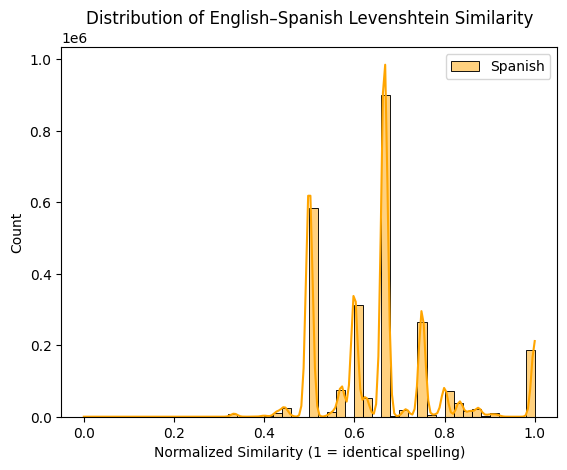

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(en_es['es_top1_sim'].dropna(), bins=50, kde=True, color='orange', label='Spanish')
plt.legend()
plt.title("Distribution of English–Spanish Levenshtein Similarity")
plt.xlabel("Normalized Similarity (1 = identical spelling)")
plt.show()

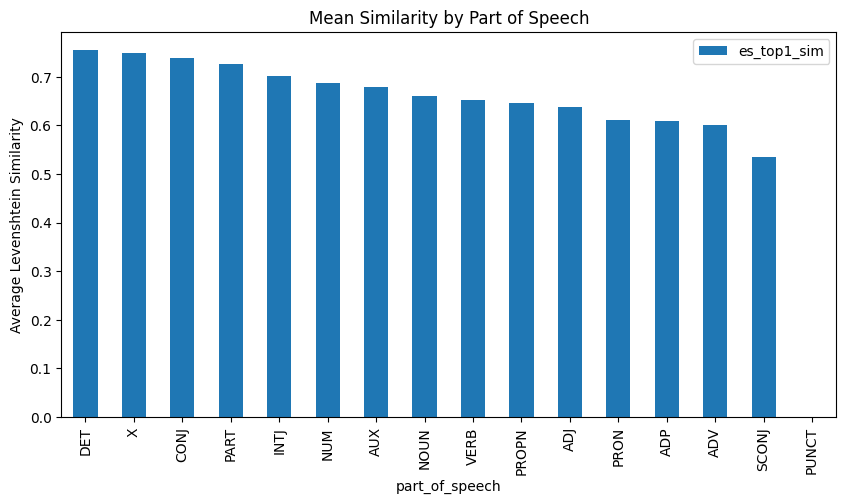

In [37]:
pos_means = (
    en_es.groupby('part_of_speech')[['es_top1_sim']]
    .mean()
    .sort_values('es_top1_sim', ascending=False)
)
pos_means.plot(kind='bar', figsize=(10,5))
plt.title("Mean Similarity by Part of Speech")
plt.ylabel("Average Levenshtein Similarity")
plt.show()

In [38]:
# Flag probably cognates
def label_cognate(sim, threshold=0.6):
    if pd.isna(sim):
        return np.nan
    return 'cognate' if sim >= threshold else 'non-cognate'

for lang in ['es']:
    en_es[f'{lang}_cognate_flag'] = en_es[f'{lang}_top1_sim'].map(label_cognate)

In [ ]:
sns.countplot(data=en_es, x='part_of_speech', hue='es_cognate_flag', order=en_es['part_of_speech'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Proportion of Likely Cognates by POS (English–Spanish)")
plt.show()